In [1]:
import pandas as pd
import numpy as np
import psycopg2

conn = psycopg2.connect(
    dbname = 'newyork',
    user = '',
    password = '',
    host = 'localhost',
    port = '5432'
)

best_nodes = ['ELLENBURG_WT_PWR', 'CHATEAUG_WT_PWR', 'CLINTON_WT_PWR', 'NORTH___COUNTRY_ESR', 'JERICHO_RISE_WT_PWR', 
              'CHAT_HIGH_FALL_HYD', 'NEG NORTH_KES_CHATEGAY', 'CHATEAUG_35_KV_LOAD', 'KNTFSRNC_46_KV_46KV_LOAD', 
              'NEG NORTH___LWR_SARANAC', 'NEG NORTH___ALICE_FALLS', 'NEG NORTH___PLATTSBURG', 'CLINTON___LFGE', 
              'NEG NORTH_FLCN_SEA', 'PLATSBRG_115KV_PMLD1', 'MARBLE_RIVER_WT_PWR', 'V_XM_10_SYNC_DSASP', 
              'FALCON___SEABRD_CC1', 'V_CMP_10_SYNC_DSASP', 'FALCON___SEABRD_CC2', 'ALTONA_WT_PWR']

# There are 58'943'742 elements in the file, so roughly 80k points per node
query = f"SELECT * FROM realtime_lbmp WHERE node IN %s"
df = pd.read_sql_query(query, conn, params=(tuple(best_nodes),))
conn.close()

df.head()

/var/folders/0x/l1m3sdhn7r59npk394yrpzk40000gn/T/ipykernel_3099/624561144.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=(tuple(best_nodes),))


,time,node,PTID,price,Marginal Cost Losses ($/MWHr),Marginal Cost Congestion ($/MWHr)
0,2023-12-23 23:40:00,MARBLE_RIVER_WT_PWR,323696,23.95,0.63,0.0
1,2023-12-23 23:40:00,NEG NORTH_FLCN_SEA,23793,24.28,0.96,0.0
2,2023-12-23 23:40:00,NEG NORTH_KES_CHATEGAY,23792,24.00,0.68,0.0
3,2023-12-23 23:40:00,NEG NORTH___ALICE_FALLS,23915,24.35,1.03,0.0
4,2023-12-23 23:40:00,NEG NORTH___LWR_SARANAC,23913,24.35,1.03,0.0


In [2]:
min_length = 1e9
for nodei in best_nodes:
    df_nodei = df[df.node==nodei]
    if len(df_nodei) < min_length:
        min_length = len(df_nodei)

# Set up as a dict, crop to shortest list
prices = {}
for nodei in best_nodes:
    prices[nodei] = list(df[df.node==nodei].price[:min_length])

for key, value in prices.items():
    print(f'{key}: {value[:10]}...')

ELLENBURG_WT_PWR: [23.91, 23.95, 23.93, 26.4, 27.13, 26.58, 26.93, 25.93, 25.89, 24.67]...
CHATEAUG_WT_PWR: [23.91, 23.95, 23.93, 26.4, 27.13, 26.58, 26.93, 25.93, 25.89, 24.67]...
CLINTON_WT_PWR: [23.91, 23.95, 23.93, 26.4, 27.13, 26.58, 26.93, 25.93, 25.89, 24.67]...
NORTH___COUNTRY_ESR: [23.91, 23.86, 23.91, 23.88, 26.35, 27.08, 26.51, 26.88, 25.86, 25.84]...
JERICHO_RISE_WT_PWR: [23.86, 23.91, 23.88, 26.35, 27.08, 26.51, 26.88, 25.86, 25.84, 24.62]...
CHAT_HIGH_FALL_HYD: [23.95, 24.0, 23.98, 26.45, 27.18, 26.61, 26.98, 25.96, 25.94, 24.71]...
NEG NORTH_KES_CHATEGAY: [24.0, 23.95, 24.0, 23.98, 26.45, 27.18, 26.61, 26.98, 25.96, 25.94]...
CHATEAUG_35_KV_LOAD: [23.95, 24.0, 23.98, 26.45, 27.18, 26.61, 26.98, 25.96, 25.94, 24.71]...
KNTFSRNC_46_KV_46KV_LOAD: [24.28, 24.33, 24.3, 26.81, 27.55, 27.0, 27.33, 26.34, 26.31, 25.07]...
NEG NORTH___LWR_SARANAC: [24.35, 24.28, 24.33, 24.3, 26.81, 27.55, 27.0, 27.33, 26.34, 26.31]...
NEG NORTH___ALICE_FALLS: [24.35, 24.28, 24.33, 24.3, 26.81, 27

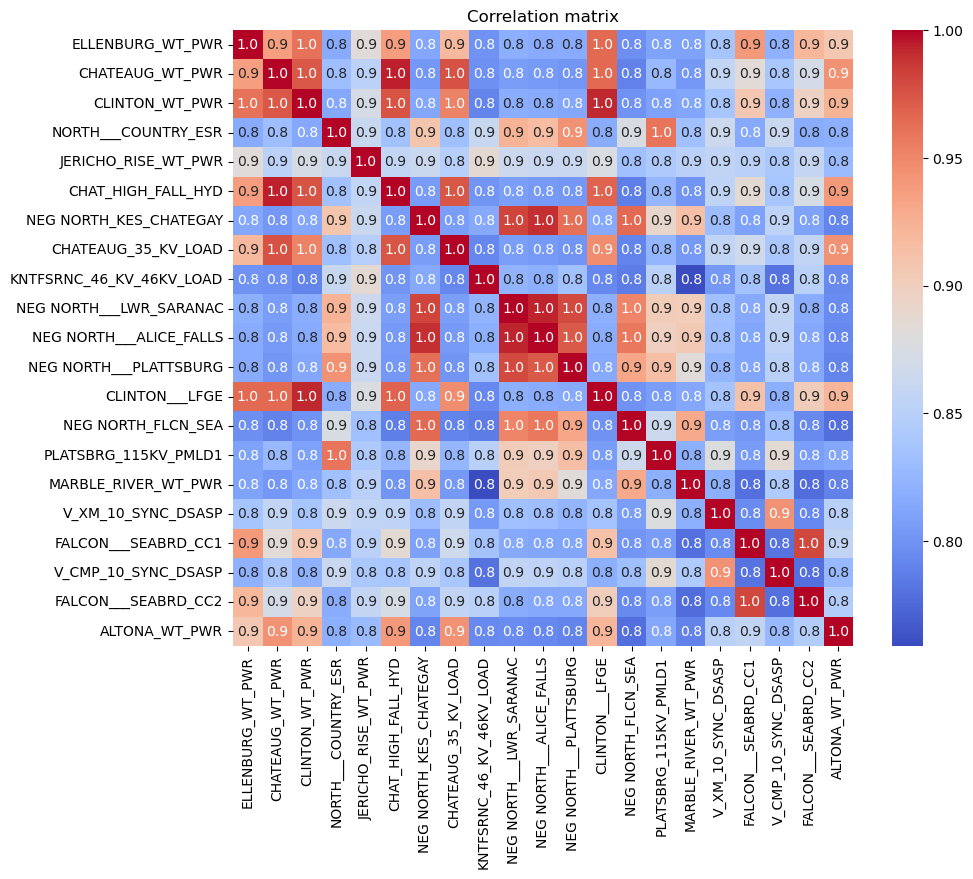

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = pd.DataFrame(prices).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation matrix')
plt.show()